<a href="https://colab.research.google.com/github/Segtanof/pyfin/blob/main/10_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning

In [ ]:
!pip install pyfixest

In [2]:
# For progress bars
from tqdm import tqdm, trange

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For data retrieval and handling
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# For evaluating the model performance
from sklearn.metrics import accuracy_score, r2_score

# Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import pyfixest as pf

import gdown

In [6]:
# Download the data file from a supplied file, because from the public source often had errors
!gdown -id 1BJ-SB3seYwz1LWBas1DiCLI2SsnYqt9B

# Load the data
housing = fetch_california_housing(data_home='/content')

# Get the predictors
X = pd.DataFrame(housing.data)
X.columns = housing.feature_names

# Take a look at the data
X.head()

usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY]
             [--speed SPEED] [--no-cookies] [--no-check-certificate]
             [--continue] [--folder] [--remaining-ok] [--format FORMAT]
             [--user-agent USER_AGENT]
             url_or_id
gdown: error: unrecognized arguments: -id


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
# Get the target
y = pd.Series(housing.target, name=housing.target_names[0])
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

## Terminology and goals

Before, we ran regressions and looked at the coefficents, t-stats, etc. to figure out if some variable of interest has an effect on the dependent variable.

**Terminology**

Now, in a machine learning context, the terminology and goals change somewhat.
Instead of *running a regression*, we now *fit a model* or *train a model*.
We no longer use our full dataset to train the model, but we typically split it into at least 2 parts.
Instead of examining which variable is driving the results within the training data, we care about the out-of-sample prediction performance.

**Goals**

This change in approach is mostly driven by a different goal.

When we *run regressions* in an econometric sense, we want to study a research question. For example, *are houses in the East or West more expensive and is this driven by different taxes?* and we might be interested in causal relationships.

For the machine learning approach, we typically care about making predictions on unseen data. For example, you might run a real estate listing website and you want to provide your users with an instant approximate house price when they provide you with some information about their house.

**Implications**

The calculations the computer does are exactly the same (for the same model and specifications, of course). But the software packages have different focuses. In a machine learning-focused package there is no way to easily get the standard regression summary table. On the other hand, it makes it very easy to build a ML pipeline.

## Data preparation

Let's prepare our data for the machine learning part. As mentioned before, we split the data into 2 parts; `train` and `test`. Sometimes, we even split the data into 3 parts, but we'll talk about why later.

Conveniently, the ML focused packages have functions for this purpose.

In [11]:
RANDOM_STATE = 4321

In [17]:
# Split the sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, X.shape

((14448, 8), (6192, 8), (20640, 8))

## Regression
Goal: We want to predict a continuous variable from a set of predictors.

This is a supervised learning problem (we have known ground truths).

### Linear regression

We have seen linear regressions before using the `pyfixest` package. Now we are implementing a similar approach using `scikit-learn`, the ML focused package.


#### pyfixest

Let's first implement the pyfixest approach. Remember that we need to specify the formula. In order to make this a bit easier, we can just use the column names from the different data parts (`y` and `X`). We also need to merge the `y` and `X` data back together, because `pyfixest` expects a single dataframe.

In [18]:
pfm = pf.feols(
    f"{y_train.name} ~ {' + '.join(X_train.columns)}",
    data=pd.concat([y_train, X_train], axis=1),
)
pfm.summary()

###

Estimation:  OLS
Dep. var.: MedHouseVal, Fixed effects: 0
Inference:  iid
Observations:  14448

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |    2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|--------:|
| Intercept     |    -37.261 |        0.794 |   -46.938 |      0.000 | -38.817 | -35.705 |
| MedInc        |      0.433 |        0.005 |    87.369 |      0.000 |   0.424 |   0.443 |
| HouseAge      |      0.010 |        0.001 |    18.093 |      0.000 |   0.009 |   0.011 |
| AveRooms      |     -0.098 |        0.007 |   -14.159 |      0.000 |  -0.111 |  -0.084 |
| AveBedrms     |      0.595 |        0.033 |    18.151 |      0.000 |   0.531 |   0.659 |
| Population    |     -0.000 |        0.000 |    -0.151 |      0.880 |  -0.000 |   0.000 |
| AveOccup      |     -0.004 |        0.001 |    -6.975 |      0.000 |  -0.005 |  -0.003 |
| Latitude      |     -0.424 |        0.009 |   -49.114 |      0.000 |  -0.441 |

From the results, we can see that `MedInc` for example has a strong effect on the house price. This way to look at the results would be the *econometrics* approach. In the ML approach, you would mostly care about the RMSE and the R2 values.

From the regression output we can see that we obtained an R2 of around `0.6`. Would this mean that we are able to explain 60% of the variance when we run *predictions*? No, because this value is the in-sample R2, based on data the model has seen during training.

Thus, to check how well the model performs out-of-sample, we need to use the `test` data we created before. This data has not been seen by the model and is thus **new** to the model! Therefore, we can judge the R2 that we are able to get on this dataset as our expected prediction performance.

In [19]:
# We use our fitted (trained) model from above to make predictions
predictions = pfm.predict(X_test)

# We calculate the R2 score based on the true data and the predicted data
r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2:.4f}')

R-squared: 0.6000


We can see that the R2 on unseen data is lower than the one we got before on the training data. This is expected, because the model was unable to *fit* to this data.

#### scikit-learn

Now we want to move to the ML-focused package `scikit-learn`, which is imported as `sklearn`.

First, we want to replicate the `pyfixest` results and show that the econometrics and ML approaches actually give the same results for the same model and specifications.

Thus, we first use the `LinearRegression` of sklearn. You can find the [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [22]:
# Set up the model with default arguments
reg = LinearRegression()
reg

LinearRegression()

In [25]:
# Fit (train) the model to the data
reg.fit(X_train, y_train)

LinearRegression()

In [27]:
# Calculate in-sample R2
train_r2 = r2_score(y_train, reg.predict(X_train))
train_r2


0.6087598771767742

In [28]:
# Make predictions
predictions = reg.predict(X_test)

In [29]:
# Evaluate the OOS model performance
test_r2 = r2_score(y_test, predictions)

In [30]:
print(f"Train R2: {train_r2:.4f}\nTest R2: {test_r2:.4f}")

Train R2: 0.6088
Test R2: 0.6000


We can see that the results are exactly the same between the two packages.

**Quick exercise:**

Extract the coefficient estimates for the `sklearn` implementation and show them with the coefficient name.

In [35]:
reg.score(X_test, y_test)

0.5999556285921104

In [37]:
pd.DataFrame(reg.coef_, index=X_train.columns)

,0
MedInc,4.332478e-01
HouseAge,9.597366e-03
AveRooms,-9.754245e-02
AveBedrms,5.949611e-01
Population,-8.646867e-07
AveOccup,-3.713167e-03
Latitude,-4.240143e-01
Longitude,-4.380147e-01


One advantage of the ML package is that it has a standardized interface. Regardless of which model one uses, they all have the `fit()` and `predict()` methods and are in general very easy to switch between.

### Decision tree

Decision trees are hierarchical structures that recursively partition the data space into smaller regions. Each node represents a feature test (like an if/else statement), branching into child nodes based on the outcome. This method is particularly powerful for capturing non-linear relationships and interactions between variables, offering transparency in decision-making processes.

Decision trees are intuitive to interpret and explain, resembling a flowchart where each split represents a decision point based on a specific feature's value.


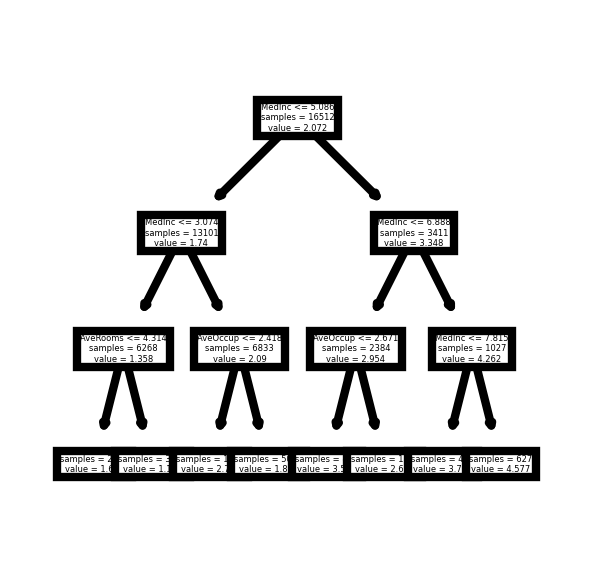

Let's see if the `DecisionTreeRegressor` performs better than the `LinearRegression`.

In [38]:
# Set up the model with the arguments and make it replicable
mdl = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [ ]:
# Fit (train) the model to the data
mdl.fit(X_train, y_train)

DecisionTreeRegressor(random_state=4321)

In [40]:
# Calculate in-sample performance metric
train_eval = r2_score(y_train, mdl.predict(X_train))

In [41]:
# Calculate the out-of-sample performance metric
test_eval = r2_score(y_test, mdl.predict(X_test))

In [42]:
print(f"""Train R2: {train_eval:.4f}
Test R2: {test_eval:.4f}""")

Train R2: 1.0000
Test R2: 0.6264


**Quick exercise**

You can see that we have quite a repetitive setting. Write a function `train_and_evaluate` that takes a model and achieves the same as above. Printing the results should be optional, default yes.

In [82]:
def train_and_eval(model, print_results=True):
    mdl = model(random_state=RANDOM_STATE)
    mdl.fit(X_train, y_train)
    train_eval = r2_score(y_train, mdl.predict(X_train))
    test_eval = r2_score(y_test, mdl.predict(X_test))
    if print_results==True:
        print(f"""Train R2: {train_eval:.4f} \n Test R2: {test_eval:.4f}""")
    return mdl , train_eval, test_eval

In [ ]:
train_and_eval(DecisionTreeRegressor, print_results=False, random)

(DecisionTreeRegressor(random_state=4321), 1.0, 0.6264423849880374)

### Keyword arguments (advanced)
All functions we have used so far had a fixed set of arguments that we could pass in. You can see that this is quite restrictive. For example if we now want to pass in some arguments to the model creation step, we cannot do so unless we specify all the potential arguments!

Fortunately, there is a way to take any number of arguments. We will only focus on keyword arguments here.
The way to do that is to add `**kwargs` to your functions' arguments.

That will "package" all keyword arguments that are not specifically specified into a dictionary called `kwargs`. You can then access the values directly from the dictionary. Let's see how this works:

In [83]:
def example_function(**kwargs):

    # kwargs is a dictionary that contains all the keyword arguments
    print(type(kwargs))
    print(kwargs.keys())

    for key, value in kwargs.items():
        print(f"{key}: {value}")

example_function(name="Alice", age=22, city="New York")

<class 'dict'>
dict_keys(['name', 'age', 'city'])
name: Alice
age: 22
city: New York


More common though is to pass on (some) of the arguments to another function within the function. You can again use `**kwargs` when calling the inner function.

In [87]:
def outer_example_function(word, print_word=True, **kwargs):
  if print_word is True:
    print(word)

  example_function(**kwargs)

outer_example_function("hello", name="Bolt", time100m=5.2)

hello
<class 'dict'>
dict_keys(['name', 'time100m'])
name: Bolt
time100m: 5.2


**Quick exercise**
Modify `train_and_evaluate` to take in additional keyword arguments and pass them to the model creation step.

In [96]:
def train_and_eval(model, print_results=True, **kwargs):
    mdl = model(**kwargs)
    mdl.fit(X_train, y_train)
    train_eval = r2_score(y_train, mdl.predict(X_train))
    test_eval = r2_score(y_test, mdl.predict(X_test))
    if print_results==True:
        print(f"""Train R2: {train_eval:.4f} \n Test R2: {test_eval:.4f}""")
    return mdl , train_eval, test_eval, kwargs

In [101]:
train_and_eval(DecisionTreeRegressor, print_results=False, random_state=RANDOM_STATE)

(DecisionTreeRegressor(random_state=4321),
 1.0,
 0.6264423849880374,
 {'random_state': 4321})

### Random forest

Random forests in Python build upon the concept of decision trees by creating an ensemble (a team) of multiple trees during training. Each tree is trained on a random subset of features and data samples, which helps to reduce overfitting and improve prediction accuracy.

More information: https://www.geeksforgeeks.org/random-forest-regression-in-python/

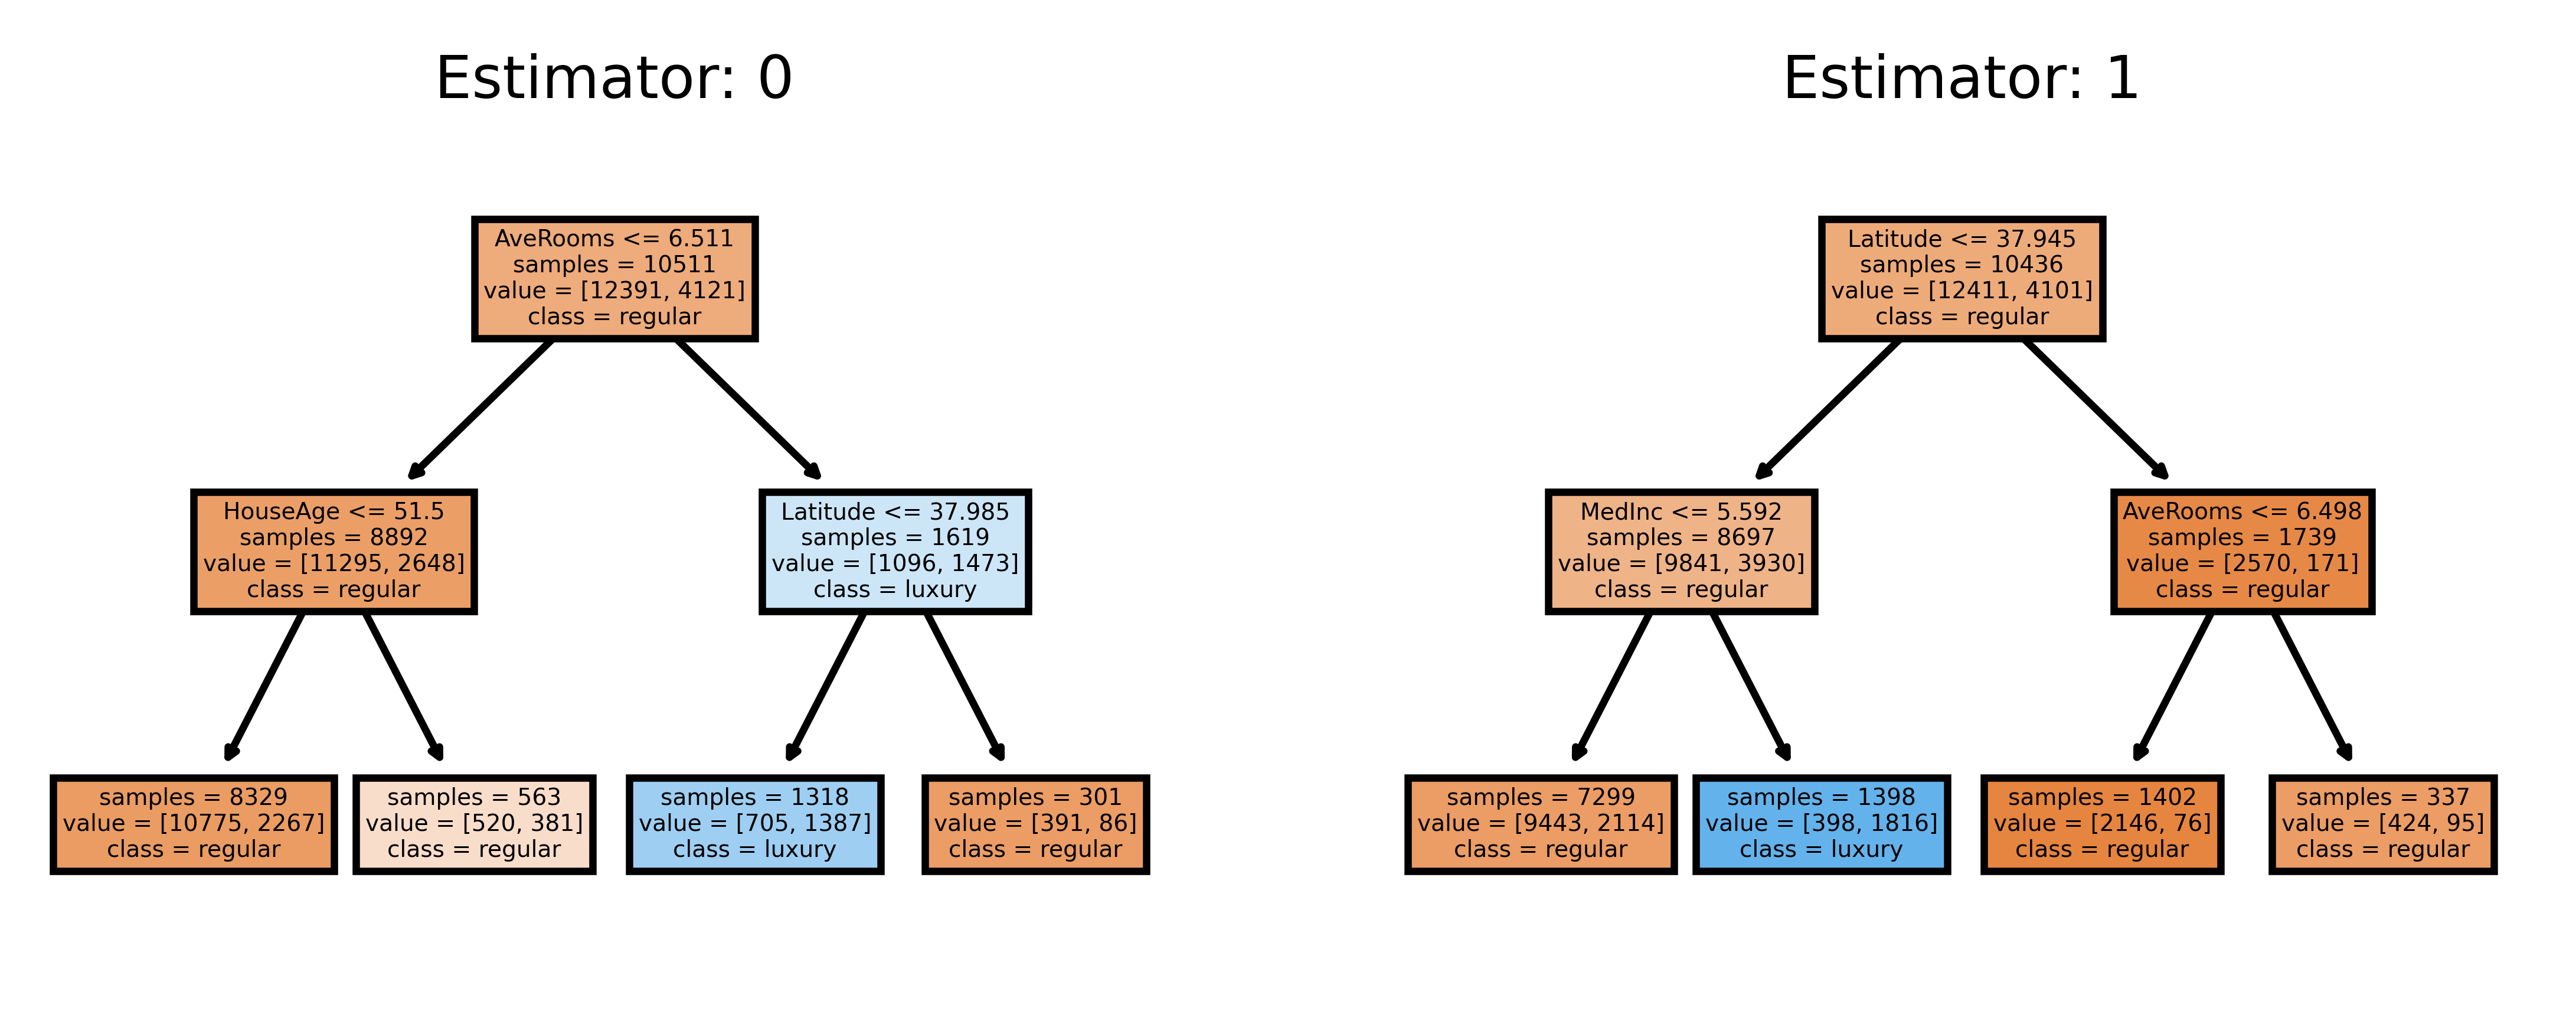

In [ ]:
train_and_evaluate(RandomForestRegressor)

**Quick exercise**

- Check the documentation for the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) to see what `n_estimators` and `max_depth` mean.
- Run your function for `n_estimators` in `(5, 10)` and `max_depth` in `(3, 20)` (in 2 separate for loops).



When doing machine learning, it is very important to split your sample into train, test and often even a validation dataset. This allows us to evaluate the model performance on 'seen' data (training data) and 'unseen' data (test & validation data).

Otherwise, it could be that the model learns the training data by heart, which yields great performances on the training data. However, the performance on unseen data will be very poor. This phenomenon is called `overfitting` and needs to be avoided.
We can spot overfitting by comparing the performance metrics in and out of sample. There is no clear-cut threshold as to when we are overfitting. Thus, this requires human interpretation and also heavily depends on the task at hand.

Example: Exams at the university. You study based on the lecture notes and the sample exams (training data). Then you go to the actual exam (unseen data).

## Classification

Goal: Determine which category an object belongs to.
Classification problems are a supervised learning problem (i.e. we have known ground truths).

Instead of R2, it is more common to use *accuracy*:
> The proportion of correctly classified instances (or samples) out of the total number of instances evaluated.

Accuracy is calculated using the following formula:

$$ \text{Accuracy} = \frac{\text{Number of correctly classified cases}}{\text{Total number of cases}} =\frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{FN} + \text{TN}} $$

Note that we are only measuring one dimension of the results! A sample imbalance can lead to deceivingly high values.
If almost all values are of class A, then a very simple "always say A" model would get a very high accuracy.

Thus, you should always calculate multiple metrics. Some keywords are:
- $\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$
- F1-score: Combines multiple aspects into one, yielding a more comprehensive picture in one number.



We cannot use a continuous variable as our prediction target. We need either binary (1 & 0) for a single-class classification or multiple values (0, 1, 2, ...) for a multi-class classification.

Thus, for our case, let's say all areas above the 75th percentile of house values are considered affluent. We are then trying to predict which areas are affluent based on all the features we have in our data.

In [ ]:
# Get the target as a class membership (i.e. True or False)
affluent_area_cutoff = y.quantile(.75) # All houses above the 75th percentile in prices are considered luxurious
y_affluent = y.ge(affluent_area_cutoff).astype(int)

**Quick exercise**

Split the sample into variables with `_clf` appended to the variable names from before (e.g. `X_train_clf`). Use a test size of 20%.

### Logistic regression
Logistic regression is used for binary classification tasks where the target variable has two possible classes.

In [ ]:
# Set up the model with the arguments and make it replicable
mdl = LogisticRegression(random_state=RANDOM_STATE)

In [ ]:
# Fit (train) the model to the data
mdl.fit(X_train_clf, y_train_clf)

In [ ]:
# Calculate in-sample performance metric
train_eval = accuracy_score(y_train_clf, mdl.predict(X_train_clf))

In [ ]:
# Calculate the out-of-sample performance metric
test_eval = accuracy_score(y_test_clf, mdl.predict(X_test_clf))

In [ ]:
print(f"""Train accuracy: {train_eval:.4f}
Test accuracy: {test_eval:.4f}""")

**Quick exercise**

Make this code a function again, like we did for the regression trees. Test it by passing the keyword argument `max_iter=1000` to the LogisticRegression model.

### Decision trees

We can run our function again with decision trees by using the DecisionTree**Classifier** class. You can see that decision trees are quite flexible.

In [ ]:
train_and_evaluate_clf(DecisionTreeClassifier)

In [ ]:
train_and_evaluate_clf(RandomForestClassifier)

**Quick exercise**

- Our fitted scikit-learn models have a `predict_proba` method. Check out what it does and apply it to the results of the `RandomForestClassifier`.
- Turn the results into a DataFrame with appropriate column names.
- Plot a histogram for the affluent column.

## Overfitting

In [ ]:
results = []
for value in trange(1,25):
  _, ins, oos = train_and_evaluate_clf(
      DecisionTreeClassifier,
      print_results=False,
      max_depth=value,
  )
  results.append({'max_depth': value, 'train': ins, 'test': oos})

In [ ]:
res = pd.DataFrame(results).set_index('max_depth')

In [ ]:
res.head()

In [ ]:
res.plot()

We can see how the training accuracy increases monotonically over the entire range of values for `max_depth`. The test accuracy on the other hand peaks earlier and decreases thereafter.

In this case we would want to use the model that we obtain for the peak of the test data. It is important to note that training performance is nice, but not the performance we actually care about. At the end of the day, we want to know how the model performs on unseen data, which we approximate by using the test dataset.

## Hyperparameters

Hyperparameters are the parameters like the max_depth, etc. This is an important concept to know about, but beyond the scope of this course.

Hyperparameter tuning is an important part of the machine learning workflow. We only used the defaults and completely ignored all of this.

One thing to keep in mind is that when you start hyperparameter tuning, you will evaluate the best parameter combination based on the model performance on the `test` dataset. This means that this data is implicitly used in your model even though it is never actually seen by the model. Due to this, using a 3-way split into train, test, and validation is recommended. Other approaches include variants of cross validation.

## Model evaluation

It is very important to determine the correct measure of model performance. For example, using R2 or accuracy may or may not be the right choice.
This strongly depends on the problem at hand, the model that is used, and many other factors.
Again, the details are beyond the scope of this course.

## Exercises

- Read the paragraph about [preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling).
- Implement the `StandardScaler` together with a `RandomForestClassifier` in a pipeline.

- [Difficult] Visualize the max_depth curve for `DecisionTreeClassifier`, `RandomForestClassifier`, and `GradientBoostingClassifier`. See the plot below for the goal. The latter two models should be run with `n_estimators` set to 50.
  
  Note that you can get the name of the model by using e.g. `model.__name__`.
  Also: Take a look at `DataFrame.melt`.

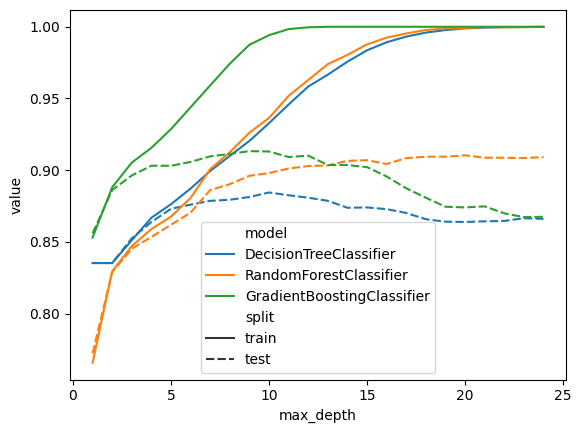